In [4]:
import torch
import pyro
import matplotlib.pyplot as plt

Suppose a Normal-Inverse Wishart prior on the mean and covariance matrix $\mu, \Sigma \sim NIW(\mu_0, \lambda, \Psi, \nu)$

In [5]:
### Prior
d=2
mu_0 = torch.zeros(2)
Psi_0 = torch.eye(2)
lbda = 1
nu = 10

We first display the prior predictive wish is defined as $p(x) = \int p(x|\mu,\Sigma) dP(\mu, \Sigma)$. 
We sample the prior predictive sequentially: 
- $\Sigma\sim IW(\Psi, \nu)$
- $\mu|\Sigma \sim N(\mu_0, \lambda^{-1}\Sigma)$
- $x|\mu, \Sigma \sim N(\mu, \Sigma)$

c:\users\ea264728\pycharmprojects\sbi\venv\lib\site-packages\torch\distributions\wishart.py:231: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


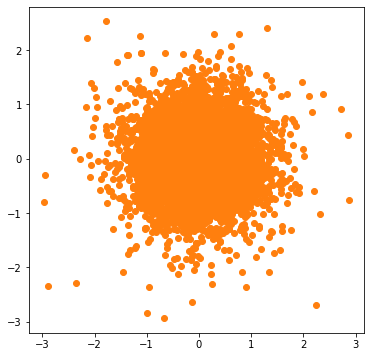

In [6]:
#Display prior predictive with sampling
number_samples = 10000
sigma_prior = torch.inverse(torch.distributions.Wishart(nu,torch.inverse(Psi_0)).sample([number_samples]))
mean_prior = torch.distributions.MultivariateNormal(mu_0,sigma_prior/lbda).sample()
prior_predictive_samples_1 = torch.distributions.MultivariateNormal(mean_prior, sigma_prior).sample()
plt.figure(figsize =(6,6))
plt.scatter(prior_predictive_samples_1[:,0].numpy(), prior_predictive_samples_1[:,1].numpy(), color = 'C1')
plt.show()

But with conjugacy of Normal-Inverse Wishart with Gaussian probability we can explicitely marginalize out the parameters $\mu, \Sigma$. The predictive distribution of a Normal-Inverse Wishart conjugate prior is a Multivariate Student t: 

$\int p(x|\mu, \Sigma) dP(\mu, \Sigma) = t_{\nu-d+1}(x; \mu_0, \frac{\Psi(\lambda +1)}{\lambda(\nu-d+1)})$

C:\Users\EA264728\AppData\Local\Temp\ipykernel_12008\3374002137.py:2: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1337.)
  prior_predictive = pyro.distributions.MultivariateStudentT(nu - d + 1, mu_0,torch.cholesky(Psi_0*(lbda+1)/(lbda*(nu- d + 1))))


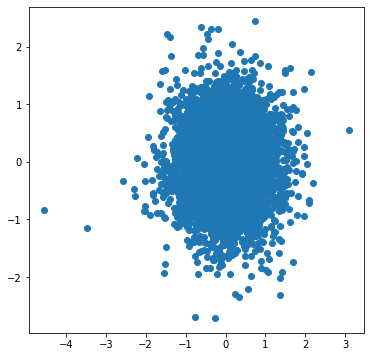

In [7]:
#Display prior predictive with marginalizing
prior_predictive = pyro.distributions.MultivariateStudentT(nu - d + 1, mu_0,torch.cholesky(Psi_0*(lbda+1)/(lbda*(nu- d + 1))))
prior_predictive_samples_2 = prior_predictive.sample([10000])
plt.figure(figsize = (6,6))
plt.scatter(prior_predictive_samples_2[:,0].numpy(), prior_predictive_samples_2[:,1].numpy(), color = 'C0')
plt.show()

We compare the samples obtained with both approached

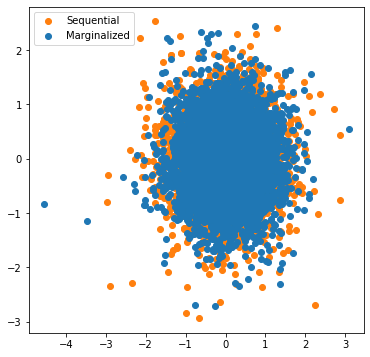

In [8]:
plt.figure(figsize = (6,6))
plt.scatter(prior_predictive_samples_1[:,0].numpy(), prior_predictive_samples_1[:,1].numpy(), color = 'C1', label ='Sequential')
plt.scatter(prior_predictive_samples_2[:,0].numpy(), prior_predictive_samples_2[:,1].numpy(), color = 'C0', label ='Marginalized')
plt.legend()
plt.show()

We will now generate observed data $x_1, ..., x_N \sim N(\mu, \Sigma)$ for some unknown values of $\mu, \Sigma$ obtained from the prior.

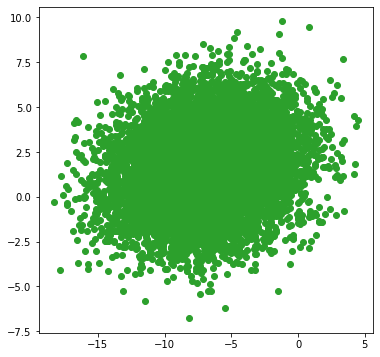

true_cov =tensor([[11.3043,  1.2832],
        [ 1.2832,  4.5940]])
true_mean =tensor([-6.8676,  1.6722])


In [9]:
true_sigma = torch.distributions.Wishart(nu,torch.inverse(Psi_0)).sample()
true_mean = torch.distributions.MultivariateNormal(mu_0,true_sigma/lbda).sample()
N = 10000
x_N  = torch.distributions.MultivariateNormal(true_mean, true_sigma).sample([N])

import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
plt.scatter(x_N[:10000,0].numpy(), x_N[:10000,1].numpy(), color = 'C2')
plt.show()
print('true_cov =' + str(true_sigma))
print('true_mean =' + str(true_mean))

Conveniently the Normal-Inverse Wishart is a conjugate prior for the Gaussian Likelihood, such that: 

$\mu, \Sigma|x_1,..., x_N \sim NIW(\mu_N, \lambda_N, \Psi_N, \nu_N)$ where: 

- $\mu_N = \frac{\lambda\mu_0 + N\bar{x}}{\lambda + N}$
- $\lambda_N = \lambda + N$
- $\Psi_N = \Psi + \sum_{i=1}^N (x_i - \bar{x})(x_i - \bar{x})^T + \frac{N\lambda}{N+\lambda}(\bar{x} - \mu_0)(\bar{x}-\mu_0)^T$
- $\nu_N = \nu + N$

In [10]:
lbda_N = lbda + N
nu_N = nu + N
empirical_mean = torch.mean(x_N, dim =0)
mu_N = (lbda*mu_0 + N*empirical_mean)/lbda_N
S = torch.cov(x_N.T)*(N-1)
temp = (empirical_mean-mu_0).unsqueeze(-1)
Psi_N = Psi_0 + S + (lbda*N*temp@temp.T)/(lbda_N)

We can obtain sample from the posterior predictive distribution $p(x|x_1,..., x_N) = \int p(x|\mu, \Sigma) dP(\mu, \Sigma|x_1,..., x_N)$ by sequentially sampling: 
- $\Sigma|x_1,..., x_N \sim IW(\Psi_N, \nu_N)$ 
- $\mu|\Sigma, x_1,..., x_N \sim N(\mu_N, \lambda_N^{-1}\Sigma)$
- $x|\mu, \Sigma \sim N(\mu, \Sigma)$

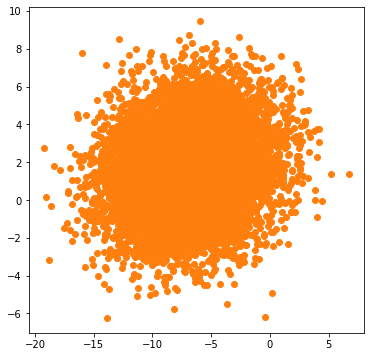

In [11]:
sigma = torch.inverse(torch.distributions.Wishart(nu_N,torch.inverse(Psi_N)).sample([10000]))
mu = torch.distributions.MultivariateNormal(mu_N, sigma/lbda_N).sample()
predictive_posterior_samples_1 = torch.distributions.MultivariateNormal(mu, sigma).sample()

plt.figure(figsize = (6,6))
plt.scatter(predictive_posterior_samples_1[:10000,0], predictive_posterior_samples_1[:10000,1], color = 'C1')
plt.show()

But once again, the posterior-predictive of a Normal-Inverse Wishart can be calculated explicitely as a multivariate Student t: 

$\int p(x|\mu, \Sigma) dP(\mu, \Sigma|x_1,..., x_N) = t_{\nu_N-d+1}(x; \mu_N, \frac{\Psi_N(\lambda_N +1)}{\lambda_N(\nu_N-d+1)})$

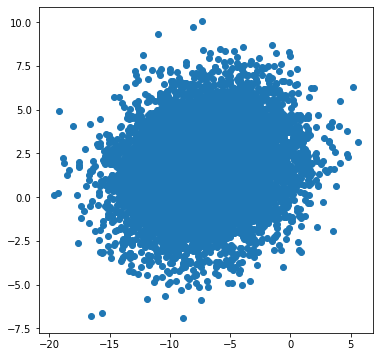

In [15]:
posterior_predictive = pyro.distributions.MultivariateStudentT(nu_N - d + 1, mu_N,torch.cholesky(Psi_N*(lbda_N+1)/(lbda_N*(nu_N - d + 1))))
posterior_predictive_samples_2 = posterior_predictive.sample([10000])

plt.figure(figsize = (6,6))
plt.scatter(posterior_predictive_samples_2[:,0].numpy(), posterior_predictive_samples_2[:,1].numpy(), color = 'C0')
plt.show()

We compare the posterior predictive samples obtained both via sequential sampling and marginalization with the original data

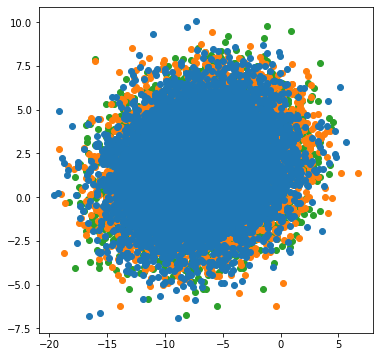

In [16]:
plt.figure(figsize = (6,6))
plt.scatter(x_N[:10000,0].numpy(), x_N[:10000,1].numpy(), color = 'C2')
plt.scatter(predictive_posterior_samples_1[:10000,0], predictive_posterior_samples_1[:10000,1], color = 'C1')
plt.scatter(posterior_predictive_samples_2[:,0].numpy(), posterior_predictive_samples_2[:,1].numpy(), color = 'C0')
plt.show()